# Notebook Principal : PIE - XREF : 
<table align="center">
    <tr><th colspan="2" style="font-size:1.2em; font-style:italic;">Elaboré par:</th></tr>
    <tr><td><em>WANG Yuran</em></td><td><em>GASSEM Adam</em></td></tr>
    <tr><td><em>GHNIMI Mohamed Neji</em></td><td><em>YANG Shuya</em></td></tr>
    <tr><td><em>HUANG Lingyun</em></td><td><em>AROUS Mohamed Amine</em></td></tr>
    <tr><td><em>HIDOURI Ameni</em></td><td><em>EZZINA Mohamed Naceur</em></td></tr>
    <tr><td><em>GHOZZI Seifeddine</em></td><td><em>BEN ARBIA Imene</em></td></tr>
    <tr><td><em>ÓPEZ NIETO Nicolás</em></td><td><em></em></td></tr>
</table>

Ce notebook présente l'utilisation de modèles de machine learning pour mesurer la similarité entre deux composants. Il commence par une analyse exploratoire des données, suivie de leur nettoyage et de leur traitement. Ensuite, différents modèles sont entraînés puis testés, à la fois via le calcul du MSE sur l'ensemble de test et par l'export d'une matrice de similarité, qui pourra ensuite être exploitée dans le script.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle

# Preparation de données

In [ ]:
# Données confidentielles
df_feat = pd.read_csv('../encoded data/opamps-features.csv') 
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

# Prétraitement

In [3]:
categorical_columns = ["Supplier_Package"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Normalisation des données numériques

In [4]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

## Analyse exploratoire des données

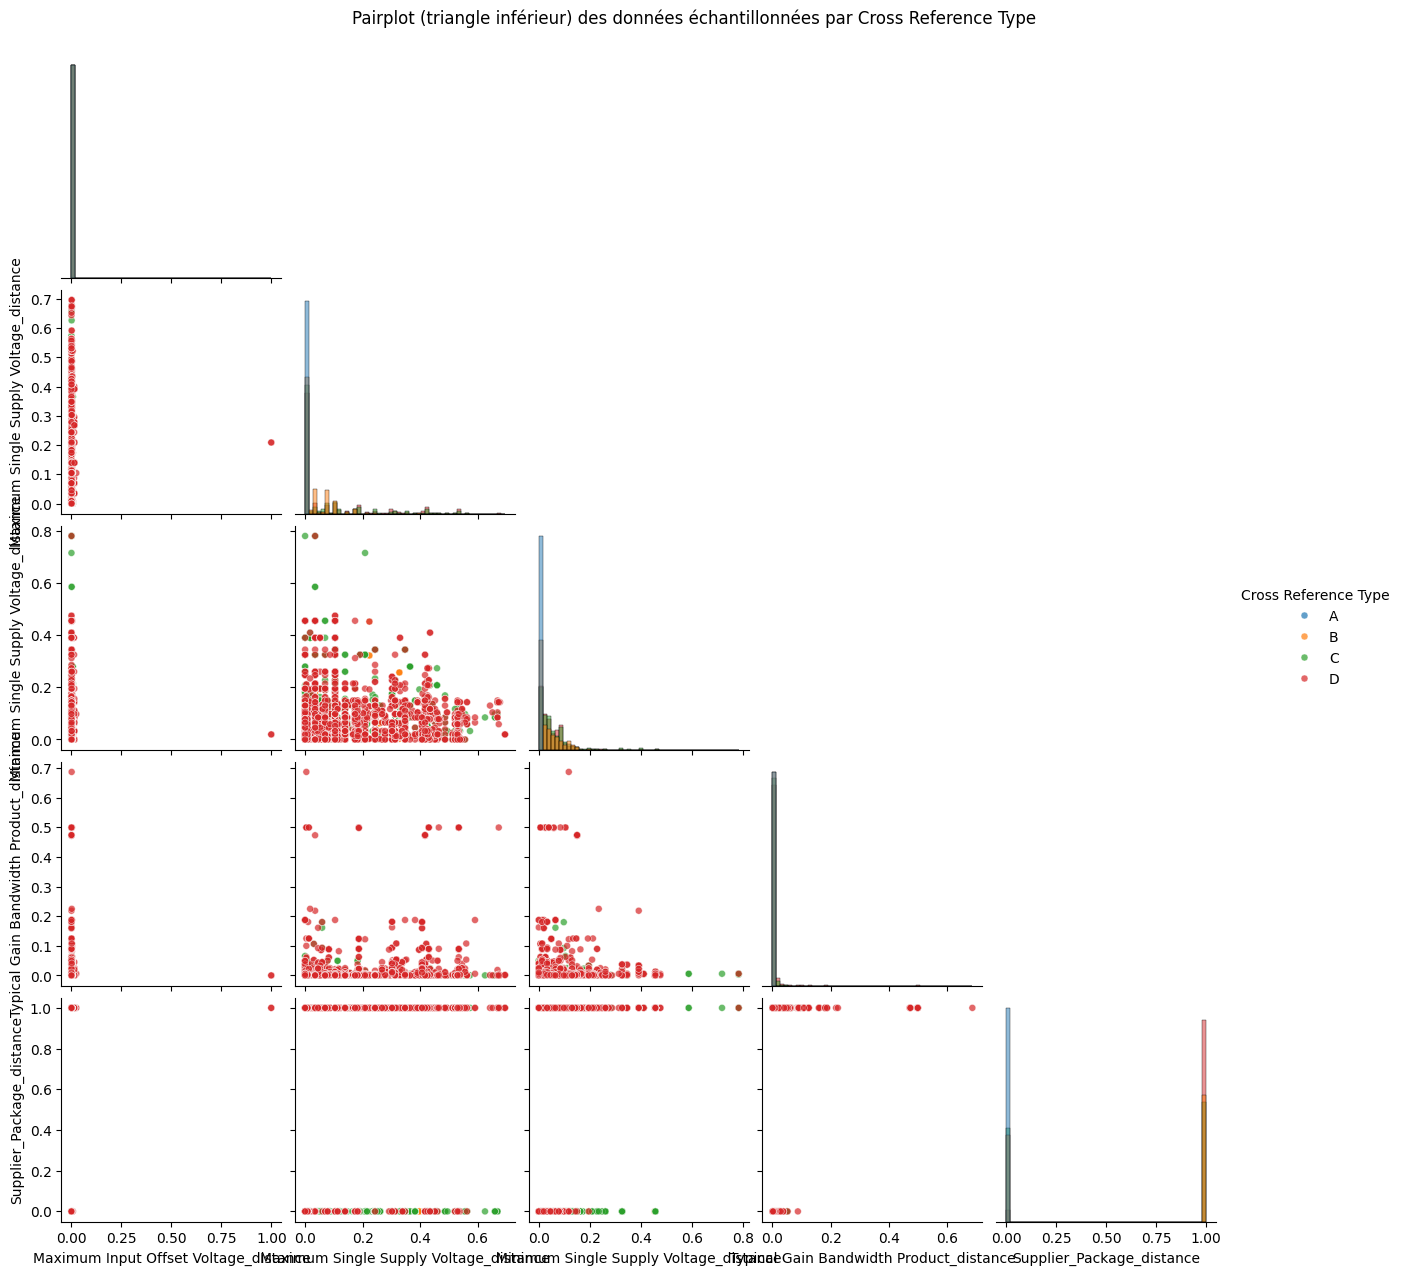

In [5]:
import helper_functions.visualize as vz

vz.visualize_distances(df)

## Conversion de la Cross Reference Type en numerique

### Y : aleatoire gaussien

In [7]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.65, 'D': 0.5}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

<Axes: xlabel='Closeness', ylabel='Density'>

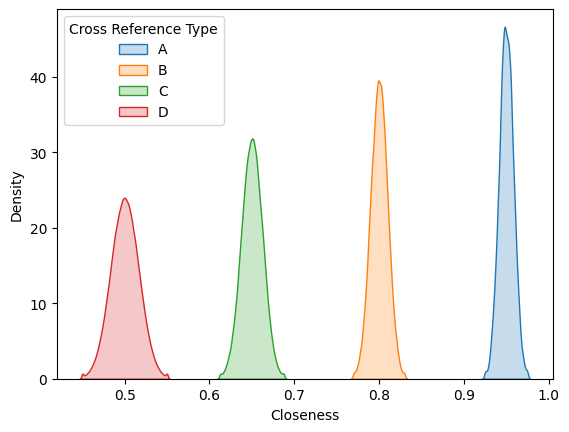

In [8]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_closeness(df,base_means,base_std,n_std=3) #gaussian distribution
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Y: fonction des distances (abs)

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_abs(df, base_means, spread,categorical_columns ,numerical_columns)


<Axes: xlabel='Closeness', ylabel='Density'>

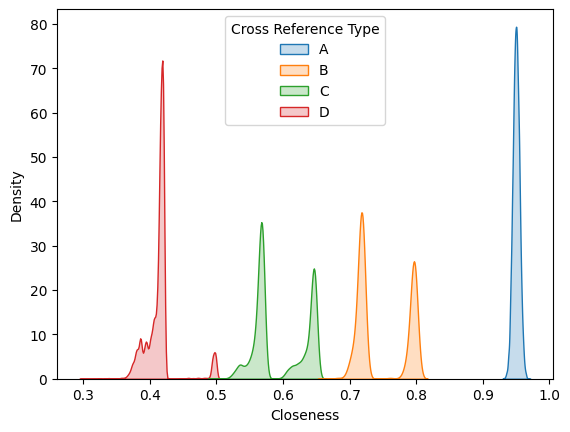

In [ ]:
# df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Y : distance power

In [ ]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Closeness'],
      dtype='object')

In [ ]:
base_means = { #neji
    'A': 0.95,  # High score for class A (most similar)
    'B': 0.75,
    'C': 0.55,
    'D': 0.35   # Low score for class D (least similar)
}
base_intervals = {
    "A": [0.88 , 0.98],
    "B": [0.7 , 0.8],
    "C" : [0.5, 0.65],
    "D" :[0.3, 0.45]
}

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_pow(df, base_intervals,categorical_columns ,numerical_columns,p=0.3)


epsilon_A shape: (18356,)


<Axes: xlabel='Closeness', ylabel='Density'>

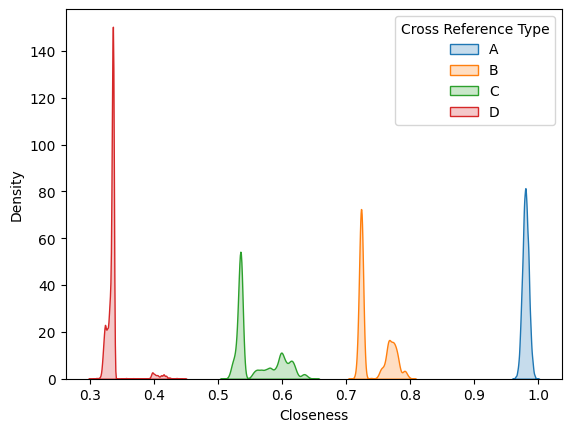

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
# for col in categorical_columns:
#   df["distance_"+col] = df[col] == df[col+"_comp"]
#   df["distance_"+col] =1- df["distance_"+col].astype(int)
# for col in numerical_columns:
#   df["distance_"+col] = np.abs(df[col] - df[col+"_comp"])
# df["distance"] = df[["distance_"+col for col in categorical_columns+numerical_columns]].sum(axis=1)

### Y : sigmoid

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_sigma(df, base_intervals,categorical_columns ,numerical_columns,k=20, midpoint=0.5)


<Axes: xlabel='Closeness', ylabel='Density'>

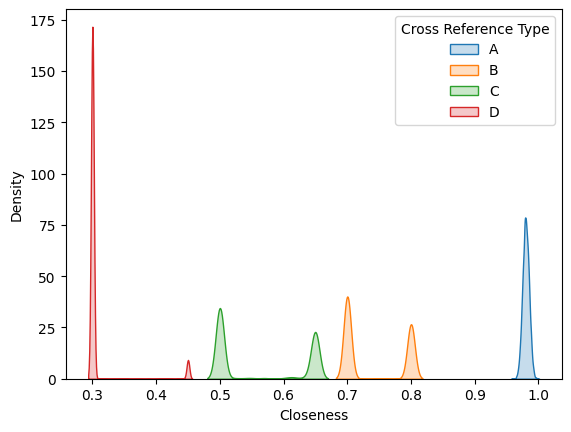

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Y : exponentielle

In [ ]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)
df = pp.generate_y_exp(df, base_intervals,categorical_columns ,numerical_columns,k=0.1)


<Axes: xlabel='Closeness', ylabel='Density'>

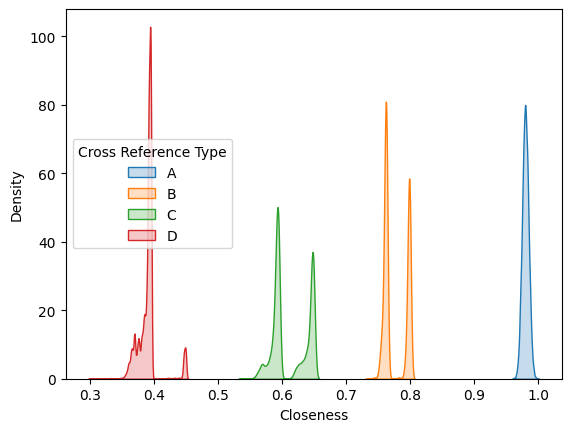

In [ ]:

sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

## Division de la Dataset

In [9]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [10]:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_validation)}")
print(f"Test size: {len(df_test)}")

Train size: 818553
Validation size: 51159
Test size: 153480


## Resolution du probleme d'equilibre des classes

Cela doit être fait sur seuleument la base d'entrainnement, sinon ça peut pas refletter la performance relle des modeles

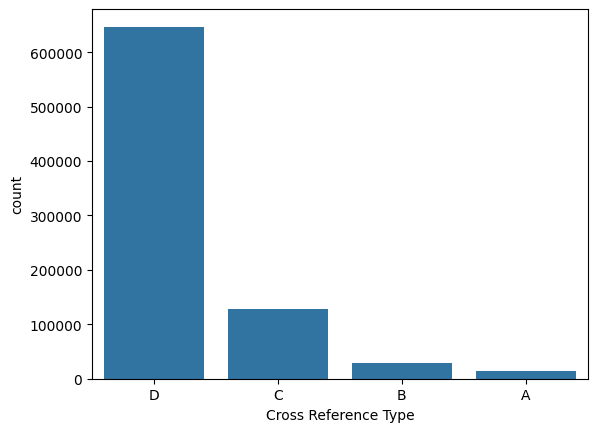

In [ ]:
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

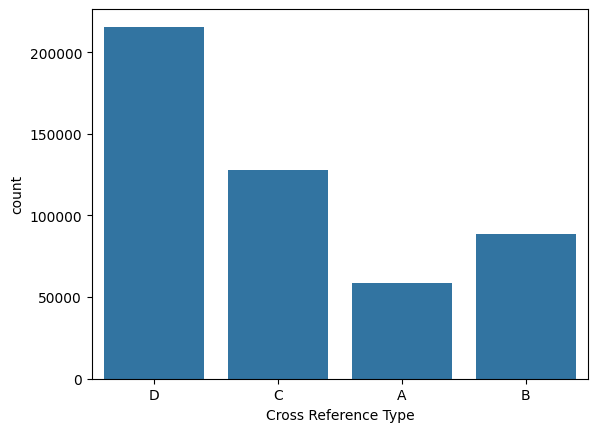

In [11]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

# Splitting Data

In [ ]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp", "Cross Reference Type"]

In [12]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp',
       'Maximum Input Offset Voltage_distance',
       'Maximum Single Supply Voltage_distance',
       'Minimum Single Supply Voltage_distance',
       'Typical Gain Bandwidth Product_distance',
       'Number of Channels per Chip_distance', 'Supplier_Package_distance',
       'total_distance', 'Closeness'],
      dtype='object')

In [ ]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp",'distance_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance' , "Cross Reference Type"]

In [ ]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [ ]:
categorical_columns+=[i +"_comp" for i in categorical_columns]

In [ ]:
categorical_columns

['Supplier_Package', 'Supplier_Package_comp']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),

    ],
    remainder='passthrough'
)

# ML models

## Matrice de similarité des données

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix_nomodel(df_feat_scaled, df)

Building closeness matrix: 100%|██████████| 1023192/1023192 [00:41<00:00, 24773.14it/s]


'closeness_matrix.npy'

In [ ]:
data = np.load("closeness_matrix.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix data.png")

In [ ]:
results = {}

## Linear Regression / witghout manufacturer

In [ ]:
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

### Entrainnement

In [ ]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix LR sans manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [10:33<00:00, 28.95it/s]


'closeness_matrix LR sans manufacturer.npy'

### Visualisation de la matrice

In [ ]:
data = np.load("closeness_matrix LR sans manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix LR.png")

### Visualization de la diagonale

<Axes: ylabel='Count'>

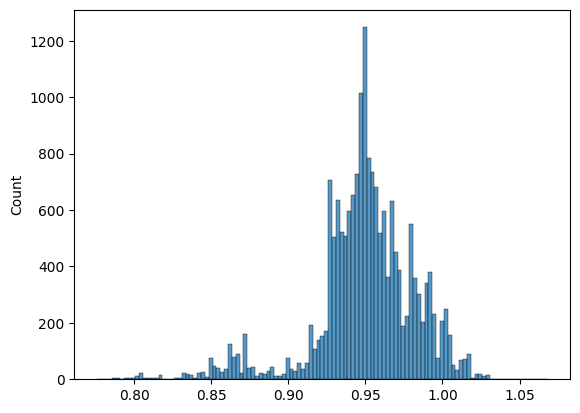

In [ ]:

sns.histplot(data.diagonal()) #repartition des score de similarité d'un produit avec lui même (doit être proche de 0.9)

## Arbre de décision

In [ ]:
from sklearn.tree import DecisionTreeRegressor
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])

### Entrainnement & Visualisation des résultats

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

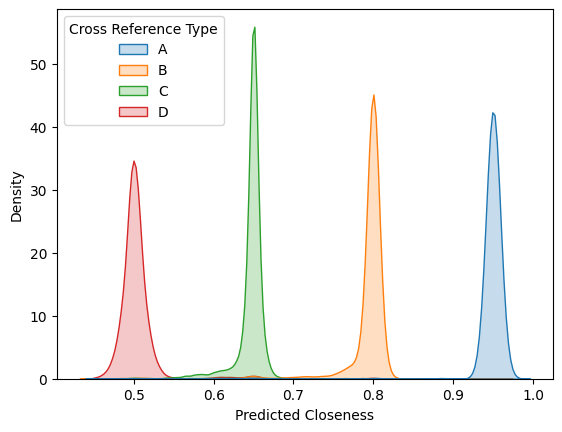

In [ ]:
pipeline.fit(X_train, y_train)
#3min 8s
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Decision Tree"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Explicabilité

In [ ]:
from sklearn.tree import export_text
tree_model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]  # Fallback if not supported

tree_rules = export_text(tree_model, feature_names=feature_names)

In [ ]:
print(tree_rules)

|--- cat__Supplier_Package_SOIC N <= 0.50
|   |--- remainder__Typical Gain Bandwidth Product <= 0.01
|   |   |--- remainder__Maximum Single Supply Voltage_comp <= 0.20
|   |   |   |--- remainder__Maximum Single Supply Voltage <= 0.19
|   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.06
|   |   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.05
|   |   |   |   |   |   |--- cat__Supplier_Package_PDIP <= 0.50
|   |   |   |   |   |   |   |--- cat__Supplier_Package_UCSP <= 0.50
|   |   |   |   |   |   |   |   |--- cat__Supplier_Package_comp_DMP <= 0.50
|   |   |   |   |   |   |   |   |   |--- remainder__Typical Gain Bandwidth Product <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- cat__Supplier_Package_SOT-23 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- cat__Supplier_Package_SOT-23 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree sans manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [11:25<00:00, 26.76it/s]


'closeness_matrix Decision Tree sans manufacturer.npy'

### Visualisation de la matrice de similarité

In [ ]:
data = np.load("closeness_matrix Decision Tree sans manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix Decision tree.png")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        device="cuda"
    ))
])

### Entrainnement

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Supplier_Package',
                                                   'MANUFACTURER',
                                                   'Supplier_Package_comp',
                                                   'MANUFACTURER_comp'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

### Visualisation des résultats

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

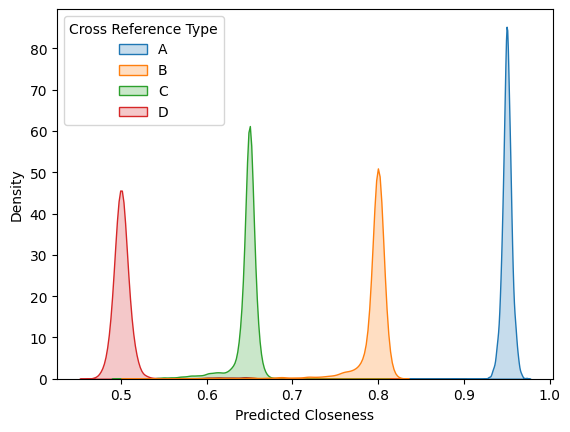

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Random forest"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt

tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Random Forest.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [1:41:48<00:00,  3.00it/s]


'closeness_matrix Random Forest.npy'

### Enregistrement du modèle

In [ ]:
# prompt: save random forest model

import pickle

# Assuming 'pipeline' is your trained RandomForestRegressor pipeline
filename = 'random_forest_model.pkl'
pickle.dump(pipeline, open(filename, 'wb'))


## Kneighborsregressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=30))
])

### Entrainnement

In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Supplier_Package',
                                                   'MANUFACTURER',
                                                   'Supplier_Package_comp',
                                                   'MANUFACTURER_comp'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=30))])

### Visualisation des résultats

In [ ]:
# Predict and store results
y_pred = pipeline.predict(X_test)
results["KNeighborsRegressor"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree.npy")

## XGBOOST

In [ ]:
from xgboost import XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,           # Increase number of trees
        max_depth=10,               # Control tree depth
        learning_rate=0.5,          # Step size for updates
        subsample=0.8,              # Fraction of samples per tree
        colsample_bytree=0.9,       # Fraction of features per tree
        reg_alpha=0.05,              # L1 regularization
        reg_lambda=0.05,             # L2 regularization
        random_state=42  ,           # For reproducibility
        device="cuda"
    ))
])

### Entrainnement & Visualisation des résultats

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

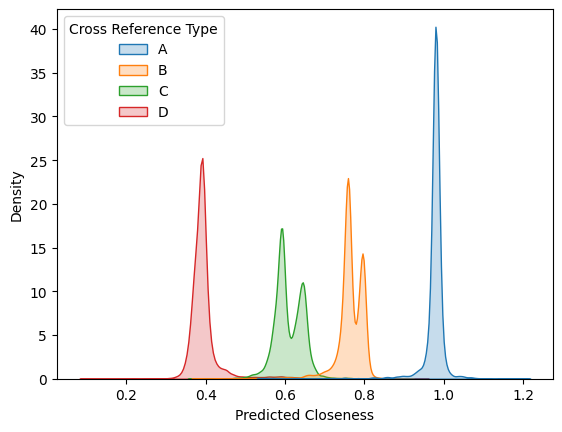

In [ ]:
pipeline.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline.predict(X_test)
results["Xgboost"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [ ]:
df_test["Predicted Closeness clipped"] = df_test["Predicted Closeness"].clip(0,1)

<Axes: xlabel='Closeness', ylabel='Density'>

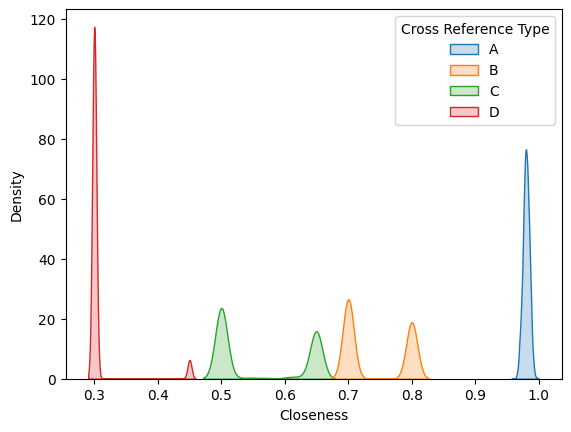

In [ ]:
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness clipped', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
# importlib.reload(tt)
name = "closeness_matrix XGBRegressor no_manufacturer new dist exponentielle k01.npy"
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path=name)

Building closeness matrix: 100%|██████████| 18352/18352 [18:29<00:00, 16.55it/s]


'closeness_matrix XGBRegressor no_manufacturer new dist exponentielle k01.npy'

### Visualisation de la matrice de similarité

In [ ]:
import numpy as np
importlib.reload(tt)
data = np.load(name, mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
#requires 8gb ram free
vz.export_matrix_downscaled(data,name="Xgboost dist exponentielle k01")

Downscaling from (18352, 18352) to (10000, 10000) ...
Saved Xgboost dist exponentielle k01 at ~(10000x10000) px, dpi=500.


In [ ]:
# requires 80gb ram
# import helper_functions.visualize as vz
# import importlib
# importlib.reload(vz)
# vz.export_matrix(data , "matrix Xgboost.png")

## LightGBM

In [ ]:
from lightgbm import LGBMRegressor

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.5,
        colsample_bytree=0.8,
        random_state=42
    ))
])

### Entrainnement & Visualisation des résultats

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 490523, number of used features: 289
[LightGBM] [Info] Start training from score 0.647107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='Predicted Closeness', ylabel='Density'>

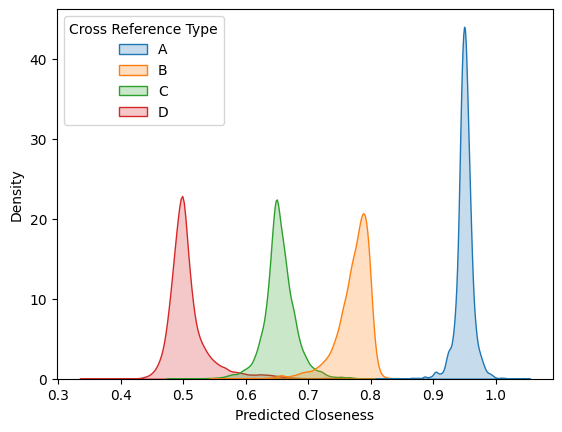

In [ ]:
pipeline_lgbm.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_lgbm.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_lgbm, output_path="closeness_matrix LGBMRegressor.npy")

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.1,
        subsample=0.8,          # Stochastic gradient boosting
        random_state=42,
    ))
])

### Entrainnement & Visualisation des résultats

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

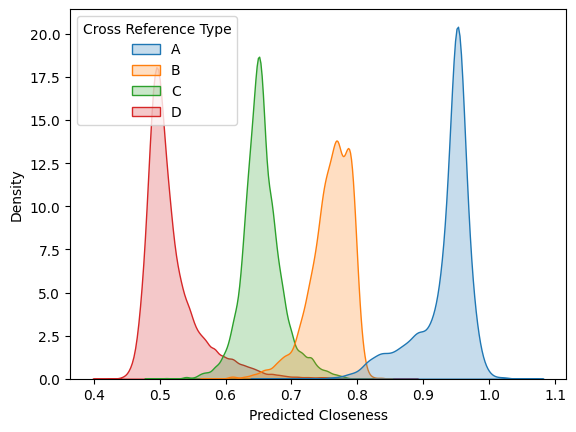

In [ ]:
pipeline_gb.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_gb.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_gb, output_path="closeness_matrix GradientBoostingRegressor no manufacturer.npy")

Building closeness matrix: 100%|██████████| 18352/18352 [1:20:35<00:00,  3.80it/s]


'closeness_matrix GradientBoostingRegressor no manufacturer.npy'

### Visualisation de la matrice de similarité

In [ ]:
data = np.load("closeness_matrix GradientBoostingRegressor no manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
# vz.export_matrix(data , "matrix GradientBoostingRegressor.png")
vz.export_matrix_downscaled(data,name="matrix GradientBoostingRegressor")

## SVR

In [ ]:
from sklearn.svm import SVR

pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        kernel='rbf',          # Radial basis function kernel
        C=1.0,                 # Regularization parameter
        epsilon=0.1            # Margin of tolerance
    ))
])

### Entrainnement & Visualisation des résultats

In [ ]:
pipeline_svr.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_svr.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_svr, output_path="closeness_matrix SVR.npy")

## Ridge

In [ ]:
from sklearn.linear_model import Ridge

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(
        alpha=1.0             # Regularization strength
    ))
])

### Entrainnement & Visualisation des résultats

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

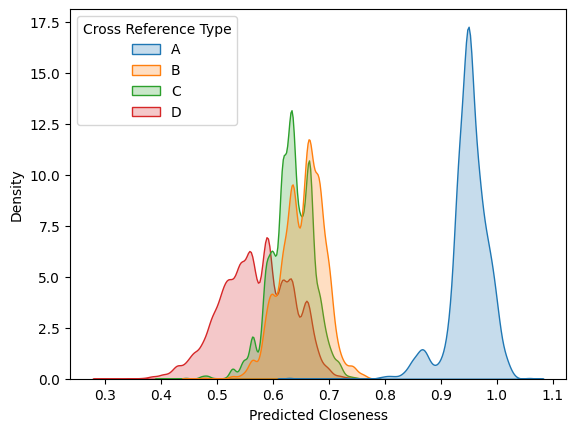

In [ ]:
pipeline_ridge.fit(X_train, y_train)

# Predict and store results
y_pred = pipeline_ridge.predict(X_test)
results["LR"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

### Export de la matrice de similarité

In [ ]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline_ridge, output_path="closeness_matrix Ridge.npy")

Building closeness matrix:  95%|█████████▍| 17421/18352 [08:15<00:24, 37.47it/s]